# Analysis 

In [92]:
import pandas as pd
import numpy as np

In [93]:
restaurant_df=pd.read_csv('restaurants1.csv')
review_df=pd.read_csv('reviews_fin.csv', sep=';')

In [94]:
review_df.head()

,business_id,review_id,text,rating,time_created,user_id,corrected_text,translated_text
0,-0iLH7iQNYtoURciDpJf6w,sxEFkJ89kyF-wMDUI2ZnWw,"Based on the menu presented, one could write a...",5,2023-12-29 23:14:16,CuqQtIpX7ZMViDuzRXxr9g,"Based on the menu presented, one could write a...","Based on the menu presented, one could write a..."
1,-0iLH7iQNYtoURciDpJf6w,n3lGqJHkjPc6SVDHOVbSNw,I like this place but it does feel a little bi...,4,2024-01-03 09:01:14,7e7hA-2b6LJV_ywPYEUO1w,I like this place but it does feel a little bi...,I like this place but it does feel a little bi...
2,-0iLH7iQNYtoURciDpJf6w,3MYKaD-tDrUVhRgDh9G4dA,"If you love French OnIon Soup, this is for you...",5,2023-12-14 13:59:59,DE6hz6gzrq67IYwH7Rh6Zg,"If you love French OnIon Soup, this is for you...","If you love French OnIon Soup, this is for you..."
3,IU9_wVOGBKjfqTTpAXpKcQ,PJuWhEzKFz3ipwhOcWMMBA,"Came here with my daughter, son inlaw his mom...",5,2023-09-22 09:36:00,dgBw2bNmgCDM21n7vKET1w,"Came here with my daughter, son in law, his mo...","Came here with my daughter, son inlaw his mom..."
4,IU9_wVOGBKjfqTTpAXpKcQ,T2k7VQB-TFkzkaEXRDfwYw,This tiny eatery along the Seine on the left b...,5,2024-01-08 16:55:09,kmSmVVb_XOpYnxSq7qns8w,This tiny eatery along the Seine on the left b...,This tiny eatery along the Seine on the left b...


### Sentiment analysis des avis en moyenne

In [95]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

In [96]:
# Initialisation de VADER
analyzer = SentimentIntensityAnalyzer()

# Fonction pour obtenir le sentiment
def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Application de la fonction à chaque avis
review_df['sentiment'] = review_df['translated_text'].apply(get_sentiment)

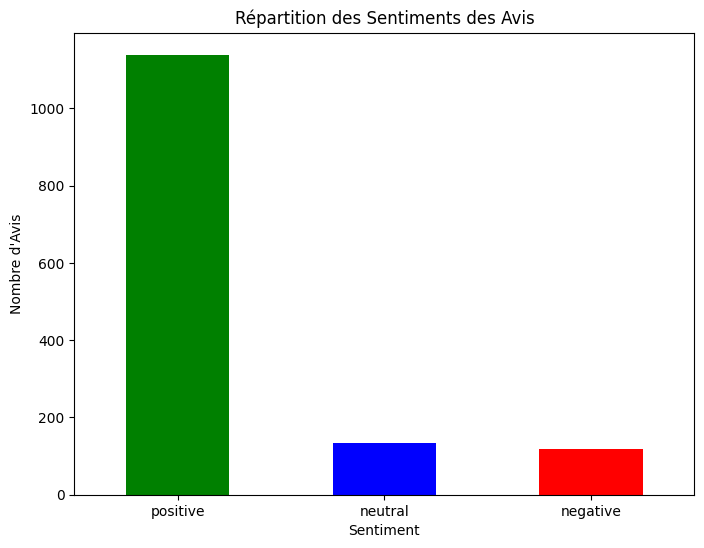

In [97]:
# Compter les sentiments
sentiment_counts = review_df['sentiment'].value_counts()

# Création d'un diagramme à barres
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Répartition des Sentiments des Avis')
plt.xlabel('Sentiment')
plt.ylabel('Nombre d\'Avis')
plt.xticks(rotation=0)
plt.show()

In [98]:
# Charger le tokenizer et le modèle
tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")
model = AutoModelForSequenceClassification.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")

# Créer une pipeline d'analyse de sentiment
sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

def analyze_sentiment(text):
    # Effectuer l'analyse de sentiment
    result = sentiment_analysis(text)

    # Récupérer le label (POSITIF ou NEGATIF) et le transformer en positif/négatif/neutre
    label = result[0]['label']
    return label

# Appliquer l'analyse de sentiment à chaque avis
review_df['sentiment'] = review_df['translated_text'].apply(analyze_sentiment)

# Afficher les résultats
print(review_df[['translated_text', 'sentiment']].head())

                                     translated_text sentiment
0  Based on the menu presented, one could write a...  positive
1  I like this place but it does feel a little bi...  positive
2  If you love French OnIon Soup, this is for you...  positive
3  Came here with my daughter, son inlaw  his mom...  negative
4  This tiny eatery along the Seine on the left b...  positive


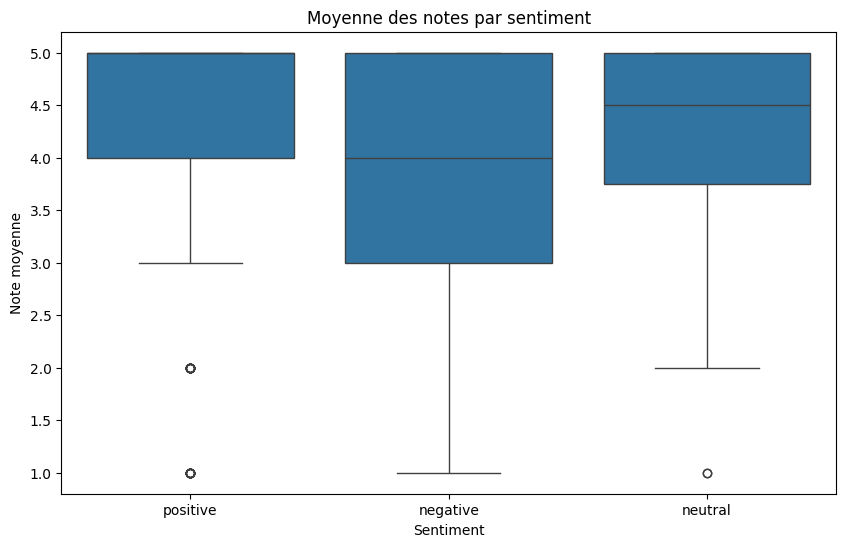

In [99]:
# Création d'un graphique pour visualiser les notes par rapport aux sentiments
plt.figure(figsize=(10, 6))

# Utiliser Seaborn pour créer un diagramme en barres
sns.boxplot(x='sentiment', y='rating', data=review_df)

# Personnaliser le graphique
plt.title('Moyenne des notes par sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Note moyenne')

# Afficher le graphique
plt.show()

### Preprocessing

In [100]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.util import ngrams
from nltk import pos_tag
import re

In [101]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    # Remplacer les contractions courantes
    contractions = {
        "n't": " not",
        "'ve": "",
        "'s": "",
        "'m": " am",
        "'ll": " will",
        "'d": " would",
        "'re": " are",
        "'t": " not"
    }
    for contraction, replacement in contractions.items():
        text = re.sub(contraction, replacement, text.lower())

    # Supprimer les caractères non alphanumériques, sauf les apostrophes
    text = re.sub(r"[^\w\s]", "", text)
    
    # Tokenisation
    tokens = word_tokenize(text)
    
    # Filtrage des stopwords et gestion des négations
    processed_tokens = []
    negation = False
    for i, token in enumerate(tokens):
        if token in stop_words and token not in ['not', 'no']:
            continue
        if negation:
            processed_tokens.append(f"not_{token}")
            negation = False
        elif token in ['not', 'no']:
            negation = True
        else:
            processed_tokens.append(token)
    
    # Création des bigrams pertinents
    bigrams = ["_".join(gram) for gram in ngrams(processed_tokens, 2) if not any(word in gram for word in stop_words)]
    
    # Concaténation des tokens et des bigrams
    return " ".join(processed_tokens + bigrams)

# Appliquer le prétraitement sur le DataFrame
review_df['preprocessed_text'] = review_df['corrected_text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sraps\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sraps\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [102]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))  # Change to 'french' for French stopwords

# Ajouter des mots non informatifs spécifiques à la liste des stopwords
additional_non_informative_words = {'one', 'us', 'want', 'come', 'go', 'get', 'make', 'even', 'would', 'could', 'le','de','like','get','restaurant','paris','also','ever'}
stop_words = stop_words.union(additional_non_informative_words)

# Fonction pour convertir la tag POS de nltk en tag utilisable par le lemmatizer
def nltk_pos_to_wordnet_pos(nltk_pos):
    if nltk_pos.startswith('J'):
        return wordnet.ADJ
    elif nltk_pos.startswith('V'):
        return wordnet.VERB
    elif nltk_pos.startswith('N'):
        return wordnet.NOUN
    elif nltk_pos.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def preprocess_text(text):
    
    contractions = {
        "n't": " not",
        "'ve": "",
        "'s": "",
        "'m": " am",
        "'ll": " will",
        "'d": " would",
        "'re": " are",
        "'t": " not"
    }
    for contraction, replacement in contractions.items():
        text = re.sub(contraction, replacement, text.lower())
    
    # Suppression des caractères non alphanumériques et mise en minuscules
    text = re.sub(r"[^\w\s]", "", text.lower())
    
    # Tokenisation
    tokens = word_tokenize(text)
    
    # Filtrage des stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Obtention des tags POS
    nltk_pos_tags = pos_tag(tokens)
    
    # Lemmatisation
    lemmas = []
    for word, nltk_pos in nltk_pos_tags:
        wordnet_pos = nltk_pos_to_wordnet_pos(nltk_pos)
        if wordnet_pos is None:
            lemma = word  # Si aucun tag POS correspondant, le mot est laissé tel quel
        else:
            lemma = lemmatizer.lemmatize(word, pos=wordnet_pos)
        lemmas.append(lemma)
    
    # Filtrage des stopwords standard et des mots non informatifs supplémentaires
    filtered_lemmas = [lemma for lemma in lemmas if lemma not in stop_words and lemma not in additional_non_informative_words]
    

    # Création des bigrams
    bigrams_list = list(ngrams(lemmas, 2))
    # Fusion des mots dans les bigrams avec un underscore pour une meilleure lisibilité
    bigrams = ['_'.join(gram) for gram in bigrams_list]

    # Création des bigrams
    trigrams_list = list(ngrams(lemmas, 3))
    # Fusion des mots dans les bigrams avec un underscore pour une meilleure lisibilité
    trigrams = ['_'.join(gram) for gram in trigrams_list]
    
    # Concaténation des tokens et des bigrams
    return " ".join(filtered_lemmas + bigrams + trigrams)

# Imaginons que review_df['corrected_text'] contienne vos avis corrigés
# Appliquer la fonction de prétraitement sur chaque avis
review_df['preprocessed_text'] = review_df['corrected_text'].apply(preprocess_text)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sraps\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sraps\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sraps\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sraps\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [103]:
review_df.head()

,business_id,review_id,text,rating,time_created,user_id,corrected_text,translated_text,sentiment,preprocessed_text
0,-0iLH7iQNYtoURciDpJf6w,sxEFkJ89kyF-wMDUI2ZnWw,"Based on the menu presented, one could write a...",5,2023-12-29 23:14:16,CuqQtIpX7ZMViDuzRXxr9g,"Based on the menu presented, one could write a...","Based on the menu presented, one could write a...",positive,base menu present write glow review classiques...
1,-0iLH7iQNYtoURciDpJf6w,n3lGqJHkjPc6SVDHOVbSNw,I like this place but it does feel a little bi...,4,2024-01-03 09:01:14,7e7hA-2b6LJV_ywPYEUO1w,I like this place but it does feel a little bi...,I like this place but it does feel a little bi...,positive,place feel little bit tourist trap people din ...
2,-0iLH7iQNYtoURciDpJf6w,3MYKaD-tDrUVhRgDh9G4dA,"If you love French OnIon Soup, this is for you...",5,2023-12-14 13:59:59,DE6hz6gzrq67IYwH7Rh6Zg,"If you love French OnIon Soup, this is for you...","If you love French OnIon Soup, this is for you...",positive,love french onion soup try comptoir la gastron...
3,IU9_wVOGBKjfqTTpAXpKcQ,PJuWhEzKFz3ipwhOcWMMBA,"Came here with my daughter, son inlaw his mom...",5,2023-09-22 09:36:00,dgBw2bNmgCDM21n7vKET1w,"Came here with my daughter, son in law, his mo...","Came here with my daughter, son inlaw his mom...",negative,daughter son law mom gratin delicious table ex...
4,IU9_wVOGBKjfqTTpAXpKcQ,T2k7VQB-TFkzkaEXRDfwYw,This tiny eatery along the Seine on the left b...,5,2024-01-08 16:55:09,kmSmVVb_XOpYnxSq7qns8w,This tiny eatery along the Seine on the left b...,This tiny eatery along the Seine on the left b...,positive,tiny eatery along seine leave bank best burger...


In [104]:
review_df[(review_df['rating'] == 1) | (review_df['rating'] == 2)].head(10)

,business_id,review_id,text,rating,time_created,user_id,corrected_text,translated_text,sentiment,preprocessed_text
27,cSw70yMlnM0eeYo2b-WRGA,7PdebIxh9qp4oKYE4aWGdA,"Service was excellent, drinks were okay, and t...",2,2023-08-21 07:56:11,027UxK4FQCRXalz-HoKWow,"Service was excellent, drinks were okay, and f...","Service was excellent, drinks were okay, and t...",positive,service excellent drink okay food barely mid a...
34,WHHt_Jb8Tgidn9mW7oDnIg,P2WEJlhrMCqdUbDEY5vLmQ,It closed three years ago. We walked all over...,1,2023-06-27 21:23:05,9cPSIY7fvmVdcqcet1tixg,It closed three years ago. We walked all over ...,It closed three years ago. We walked all over...,negative,close three year ago walk look told close anot...
35,WHHt_Jb8Tgidn9mW7oDnIg,5vj46mglCUT8_jVFgO8L7g,Doesn't exist at the address listed I double a...,1,2022-07-22 12:23:01,NguGOkT5QDUwk_qkBQ0j_Q,Doesn't exist at the address listed I double c...,Doesn't exist at the address listed I double a...,negative,exist address list double checked google map a...
37,ijqSzadlZ9SCXvUEpMimcA,lBDf2KXJtrFLWq0LQ9gxCA,As im standing outside in this cold weather im...,1,2023-12-27 22:51:52,xnMexMFn8WBsx2B2LLjyXg,"As I am standing outside in this cold weather,...",As im standing outside in this cold weather im...,negative,stand outside cold weather kinda frustrate wak...
49,u0PQ2A4w14iMWrrk5pWGUA,j7UIOeMdrlJ76jjlwpxa5g,RACIST and unrespectful.\r\n\r\nI ordered a 3 ...,1,2023-11-07 10:49:00,cuc7MgP1lEM6LgMbX5KzHw,I ordered a 3 course diner wine coffee that co...,RACIST and unrespectful.\r\n\r\nI ordered a 3 ...,negative,order 3 course diner wine coffee cost 65 euro ...
59,e6RHSG0d94yzA3McN-eFxg,wNCnYnOsQhRNt0QBIMeXBA,Could not find it with directions provided. Do...,1,2023-10-01 13:38:18,Ave6QKhnZlZMPIi3P6Nu1w,Could not find it with directions provided. Do...,Could not find it with directions provided. Do...,neutral,find direction provide still exist stay close ...
64,lTGYl3EcDKgXUhKpd7qQsw,L0YbpomUVmsmZDasgntUag,I was served a singularly mediocre Croque Mada...,2,2024-01-09 08:35:21,cmjhtZOE5Ni5bwZKH3skFQ,I was served a singularly mediocre Croque Mada...,I was served a singularly mediocre Croque Mada...,positive,serve singularly mediocre croque madame far we...
76,sFdV05m6Pw5Rw6DdrpQlIw,EZzLbtwOWjSpCkW2f6ec5g,This was literally the first restaurant we hea...,2,2023-11-30 19:43:46,UGOjCCpSFFZkQZoLh5MRjA,This was literally the first restaurant we hea...,This was literally the first restaurant we hea...,negative,literally first head drop luggage hotel room u...
98,_qACPRqSQ6Nvd20H8EY3uw,L0_zS5LJup3XEHa_Yf2F7g,I don't like make reviews on places that I don...,1,2023-10-15 15:47:20,RHBEH_PAHLXaX8qeAe8_gQ,I don't like to make reviews on places that I ...,I don't like make reviews on places that I don...,negative,review place post good bad unfortunately good ...
147,28m3vU-aLX76lMEyT3WL5Q,dc3Dle3nSRrJM0wzSWZ3Dw,I came to Paris in May and made a reservation ...,1,2023-10-02 09:32:22,UOPLEBptg7hEzGT_k6wyTw,I came to Paris in May and made a reservation ...,I came to Paris in May and made a reservation ...,positive,may reservation month advance monday open 1900...


In [105]:
review_df[(review_df['rating'] == 4) | (review_df['rating'] == 5)].shape

(1220, 10)

In [106]:
review_df[((review_df['rating'] == 1) | (review_df['rating'] == 2))].shape

(81, 10)

In [107]:
review_df[(review_df['rating'] == 5) & (review_df['sentiment'] == 'negative')].shape

(114, 10)

In [108]:
review_df[((review_df['rating'] == 1) | (review_df['rating'] == 2)) & (review_df['sentiment'] == 'negative')].size

520

In [109]:
review_df.shape

(1393, 10)

In [110]:
review_df[(review_df['rating'] == 3)].size

920

In [111]:
review_df[review_df.rating==1].head()

,business_id,review_id,text,rating,time_created,user_id,corrected_text,translated_text,sentiment,preprocessed_text
34,WHHt_Jb8Tgidn9mW7oDnIg,P2WEJlhrMCqdUbDEY5vLmQ,It closed three years ago. We walked all over...,1,2023-06-27 21:23:05,9cPSIY7fvmVdcqcet1tixg,It closed three years ago. We walked all over ...,It closed three years ago. We walked all over...,negative,close three year ago walk look told close anot...
35,WHHt_Jb8Tgidn9mW7oDnIg,5vj46mglCUT8_jVFgO8L7g,Doesn't exist at the address listed I double a...,1,2022-07-22 12:23:01,NguGOkT5QDUwk_qkBQ0j_Q,Doesn't exist at the address listed I double c...,Doesn't exist at the address listed I double a...,negative,exist address list double checked google map a...
37,ijqSzadlZ9SCXvUEpMimcA,lBDf2KXJtrFLWq0LQ9gxCA,As im standing outside in this cold weather im...,1,2023-12-27 22:51:52,xnMexMFn8WBsx2B2LLjyXg,"As I am standing outside in this cold weather,...",As im standing outside in this cold weather im...,negative,stand outside cold weather kinda frustrate wak...
49,u0PQ2A4w14iMWrrk5pWGUA,j7UIOeMdrlJ76jjlwpxa5g,RACIST and unrespectful.\r\n\r\nI ordered a 3 ...,1,2023-11-07 10:49:00,cuc7MgP1lEM6LgMbX5KzHw,I ordered a 3 course diner wine coffee that co...,RACIST and unrespectful.\r\n\r\nI ordered a 3 ...,negative,order 3 course diner wine coffee cost 65 euro ...
59,e6RHSG0d94yzA3McN-eFxg,wNCnYnOsQhRNt0QBIMeXBA,Could not find it with directions provided. Do...,1,2023-10-01 13:38:18,Ave6QKhnZlZMPIi3P6Nu1w,Could not find it with directions provided. Do...,Could not find it with directions provided. Do...,neutral,find direction provide still exist stay close ...


In [112]:
review_df.head()

,business_id,review_id,text,rating,time_created,user_id,corrected_text,translated_text,sentiment,preprocessed_text
0,-0iLH7iQNYtoURciDpJf6w,sxEFkJ89kyF-wMDUI2ZnWw,"Based on the menu presented, one could write a...",5,2023-12-29 23:14:16,CuqQtIpX7ZMViDuzRXxr9g,"Based on the menu presented, one could write a...","Based on the menu presented, one could write a...",positive,base menu present write glow review classiques...
1,-0iLH7iQNYtoURciDpJf6w,n3lGqJHkjPc6SVDHOVbSNw,I like this place but it does feel a little bi...,4,2024-01-03 09:01:14,7e7hA-2b6LJV_ywPYEUO1w,I like this place but it does feel a little bi...,I like this place but it does feel a little bi...,positive,place feel little bit tourist trap people din ...
2,-0iLH7iQNYtoURciDpJf6w,3MYKaD-tDrUVhRgDh9G4dA,"If you love French OnIon Soup, this is for you...",5,2023-12-14 13:59:59,DE6hz6gzrq67IYwH7Rh6Zg,"If you love French OnIon Soup, this is for you...","If you love French OnIon Soup, this is for you...",positive,love french onion soup try comptoir la gastron...
3,IU9_wVOGBKjfqTTpAXpKcQ,PJuWhEzKFz3ipwhOcWMMBA,"Came here with my daughter, son inlaw his mom...",5,2023-09-22 09:36:00,dgBw2bNmgCDM21n7vKET1w,"Came here with my daughter, son in law, his mo...","Came here with my daughter, son inlaw his mom...",negative,daughter son law mom gratin delicious table ex...
4,IU9_wVOGBKjfqTTpAXpKcQ,T2k7VQB-TFkzkaEXRDfwYw,This tiny eatery along the Seine on the left b...,5,2024-01-08 16:55:09,kmSmVVb_XOpYnxSq7qns8w,This tiny eatery along the Seine on the left b...,This tiny eatery along the Seine on the left b...,positive,tiny eatery along seine leave bank best burger...


In [113]:
from collections import Counter
import itertools
from wordcloud import WordCloud

In [114]:
# Combiner tous les textes prétraités en une liste
all_words = list(itertools.chain(*review_df['preprocessed_text'].str.split()))

# Compter la fréquence de chaque mot/n-gram
word_freq = Counter(all_words)

# Sélectionner un certain nombre de mots les plus fréquents
num_words = 100  # par exemple, les 100 mots les plus fréquents
most_common_words = dict(word_freq.most_common(num_words))

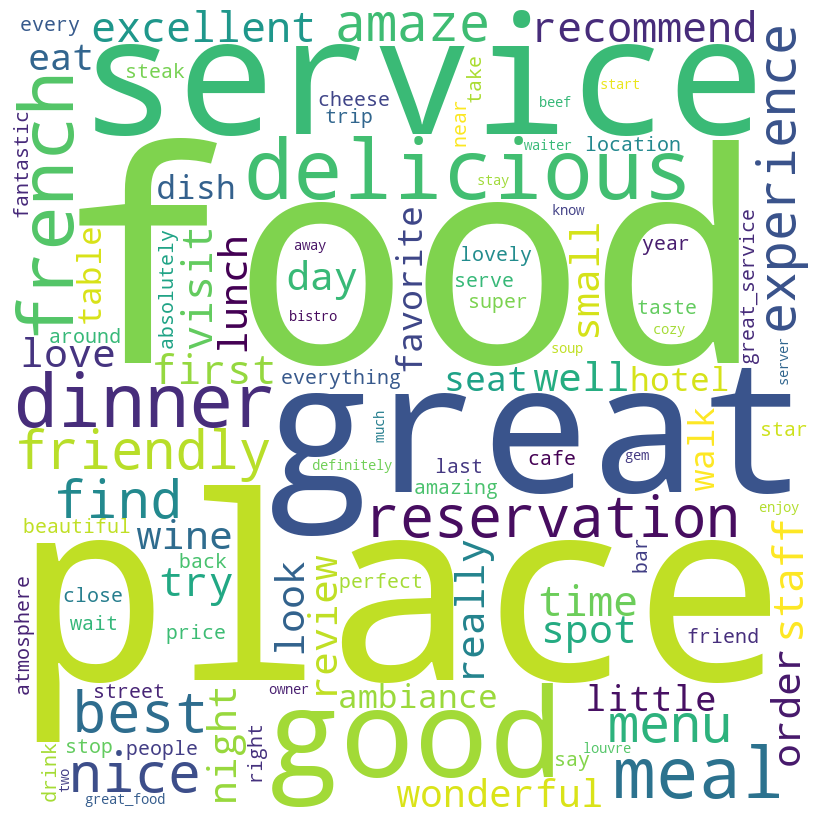

In [115]:
# Création du WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(most_common_words)

# Affichage du WordCloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [116]:
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.tokenize import word_tokenize

### LDA TOPIC MODELING

In [117]:
# Préparation des données pour LDA
# Tokenisation des avis prétraités
texts = [word_tokenize(doc) for doc in review_df['preprocessed_text']]

# Création d'un dictionnaire qui mappe chaque mot à un id unique
dictionary = corpora.Dictionary(texts)

# Filtrage des mots extrêmement rares et trop fréquents pour améliorer la qualité des topics
dictionary.filter_extremes(no_below=100, no_above=0.5, keep_n=10000)

# Transformation des documents en vecteurs de sac de mots (Bag of Words)
corpus = [dictionary.doc2bow(text) for text in texts]

# Entraînement du modèle LDA
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=4,
                     random_state=100,
                     update_every=1,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

# Obtenir les topics
topics = lda_model.print_topics(num_words=4)  # Changer le nombre de mots par topic si nécessaire

for topic in topics:
    print(topic)


(0, '0.375*"service" + 0.266*"delicious" + 0.234*"food" + 0.080*"great"')
(1, '0.536*"good" + 0.252*"reservation" + 0.088*"place" + 0.050*"service"')
(2, '0.362*"food" + 0.346*"place" + 0.142*"french" + 0.073*"meal"')
(3, '0.523*"great" + 0.237*"dinner" + 0.132*"best" + 0.064*"meal"')


In [118]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Activer pyLDAvis dans Jupyter Notebook (pas nécessaire si vous utilisez JupyterLab ou une autre interface)
pyLDAvis.enable_notebook()

# Préparation des données pour pyLDAvis
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Affichage de la visualisation
pyLDAvis.display(lda_display)


### Embedding

In [119]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

# Préparation des données pour Word2Vec (tokenisation a déjà été faite)
texts = [text.split() for text in review_df['preprocessed_text']]

# Entraînement du modèle Word2Vec
w2v_model = Word2Vec(texts,vector_size=80, window=5, min_count=1, workers=2)

# Enregistrer le modèle pour une utilisation ultérieure
w2v_model.save("word2vec_model.model")

In [120]:
# Trouver des mots similaires
similar_words = w2v_model.wv.most_similar('dinner', topn=10) 
print(similar_words)

[('sit_meal', 0.406647652387619), ('poke_bowl', 0.3999577760696411), ('must', 0.39791736006736755), ('place_unassuming', 0.39432546496391296), ('24hours_eat_oh', 0.3937075138092041), ('strip_sailor_sweater', 0.3877899944782257), ('street_picture', 0.3866836428642273), ('nondairy_milk', 0.38266614079475403), ('occasion', 0.3767959177494049), ('anyone_visit_france', 0.3702080249786377)]


#### Semantic Research

In [121]:
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

def semantic_search(query, model, texts, top_n=5):
    # Tokeniser et calculer la moyenne des vecteurs de mots pour la requête
    query_tokens = query.split()
    query_vector = average_word_vectors(query_tokens, model, set(model.wv.index_to_key), model.vector_size)
    
    # Calculer la moyenne des vecteurs de mots pour chaque document
    docs_vectors = [average_word_vectors(text.split(), model, set(model.wv.index_to_key), model.vector_size) for text in texts]
    
    # Calculer la similarité cosinus entre la requête et chaque document
    similarities = cosine_similarity([query_vector], docs_vectors).flatten()
    similar_indices = similarities.argsort()[-top_n:][::-1]
    similar_texts = [(texts[i], similarities[i]) for i in similar_indices]
    
    return similar_texts

# Exemple de recherche sémantique
query = "great food and service"
print(semantic_search(query, w2v_model, review_df['preprocessed_text'].tolist()))

[('friendly service excellent french food despite fact touristy area quality service food great friendly_service service_excellent excellent_french french_food food_despite despite_fact fact_touristy touristy_area area_quality quality_service service_food food_great friendly_service_excellent service_excellent_french excellent_french_food french_food_despite food_despite_fact despite_fact_touristy fact_touristy_area touristy_area_quality area_quality_service quality_service_food service_food_great', 0.8183215229060994), ('place excellent really popular local service excellent food great place_excellent excellent_really really_popular popular_local local_service service_excellent excellent_food food_great place_excellent_really excellent_really_popular really_popular_local popular_local_service local_service_excellent service_excellent_food excellent_food_great', 0.7903653921612614), ('place great great food great service fly exhaust good meal little nervous place_great great_great grea

In [140]:
review_df.head()

,business_id,review_id,text,rating,time_created,user_id,corrected_text,translated_text,sentiment,preprocessed_text,preprocessed_text2
0,-0iLH7iQNYtoURciDpJf6w,sxEFkJ89kyF-wMDUI2ZnWw,"Based on the menu presented, one could write a...",5,2023-12-29 23:14:16,CuqQtIpX7ZMViDuzRXxr9g,"Based on the menu presented, one could write a...","Based on the menu presented, one could write a...",positive,base menu present write glow review classiques...,"[based, on, the, menu, presented, ,, one, coul..."
1,-0iLH7iQNYtoURciDpJf6w,n3lGqJHkjPc6SVDHOVbSNw,I like this place but it does feel a little bi...,4,2024-01-03 09:01:14,7e7hA-2b6LJV_ywPYEUO1w,I like this place but it does feel a little bi...,I like this place but it does feel a little bi...,positive,place feel little bit tourist trap people din ...,"[i, like, this, place, but, it, does, feel, a,..."
2,-0iLH7iQNYtoURciDpJf6w,3MYKaD-tDrUVhRgDh9G4dA,"If you love French OnIon Soup, this is for you...",5,2023-12-14 13:59:59,DE6hz6gzrq67IYwH7Rh6Zg,"If you love French OnIon Soup, this is for you...","If you love French OnIon Soup, this is for you...",positive,love french onion soup try comptoir la gastron...,"[if, you, love, french, onion, soup, ,, this, ..."
3,IU9_wVOGBKjfqTTpAXpKcQ,PJuWhEzKFz3ipwhOcWMMBA,"Came here with my daughter, son inlaw his mom...",5,2023-09-22 09:36:00,dgBw2bNmgCDM21n7vKET1w,"Came here with my daughter, son in law, his mo...","Came here with my daughter, son inlaw his mom...",negative,daughter son law mom gratin delicious table ex...,"[came, here, with, my, daughter, ,, son, inlaw..."
4,IU9_wVOGBKjfqTTpAXpKcQ,T2k7VQB-TFkzkaEXRDfwYw,This tiny eatery along the Seine on the left b...,5,2024-01-08 16:55:09,kmSmVVb_XOpYnxSq7qns8w,This tiny eatery along the Seine on the left b...,This tiny eatery along the Seine on the left b...,positive,tiny eatery along seine leave bank best burger...,"[this, tiny, eatery, along, the, seine, on, th..."


In [177]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

text_preprocess=[re.sub(r"[^\w\s]", "", doc.lower() )for doc in review_df['translated_text']]
review_df['preprocessed_text2']=text_preprocess
review_df.head()

,business_id,review_id,text,rating,time_created,user_id,corrected_text,translated_text,sentiment,preprocessed_text,preprocessed_text2,sentiment_rating
0,-0iLH7iQNYtoURciDpJf6w,sxEFkJ89kyF-wMDUI2ZnWw,"Based on the menu presented, one could write a...",5,2023-12-29 23:14:16,CuqQtIpX7ZMViDuzRXxr9g,"Based on the menu presented, one could write a...","Based on the menu presented, one could write a...",positif,base menu present write glow review classiques...,based on the menu presented one could write a ...,positif
1,-0iLH7iQNYtoURciDpJf6w,n3lGqJHkjPc6SVDHOVbSNw,I like this place but it does feel a little bi...,4,2024-01-03 09:01:14,7e7hA-2b6LJV_ywPYEUO1w,I like this place but it does feel a little bi...,I like this place but it does feel a little bi...,positif,place feel little bit tourist trap people din ...,i like this place but it does feel a little bi...,positif
2,-0iLH7iQNYtoURciDpJf6w,3MYKaD-tDrUVhRgDh9G4dA,"If you love French OnIon Soup, this is for you...",5,2023-12-14 13:59:59,DE6hz6gzrq67IYwH7Rh6Zg,"If you love French OnIon Soup, this is for you...","If you love French OnIon Soup, this is for you...",positif,love french onion soup try comptoir la gastron...,if you love french onion soup this is for you ...,positif
3,IU9_wVOGBKjfqTTpAXpKcQ,PJuWhEzKFz3ipwhOcWMMBA,"Came here with my daughter, son inlaw his mom...",5,2023-09-22 09:36:00,dgBw2bNmgCDM21n7vKET1w,"Came here with my daughter, son in law, his mo...","Came here with my daughter, son inlaw his mom...",positif,daughter son law mom gratin delicious table ex...,came here with my daughter son inlaw his mom ...,positif
4,IU9_wVOGBKjfqTTpAXpKcQ,T2k7VQB-TFkzkaEXRDfwYw,This tiny eatery along the Seine on the left b...,5,2024-01-08 16:55:09,kmSmVVb_XOpYnxSq7qns8w,This tiny eatery along the Seine on the left b...,This tiny eatery along the Seine on the left b...,positif,tiny eatery along seine leave bank best burger...,this tiny eatery along the seine on the left b...,positif


              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00        19
      neutre       0.00      0.00      0.00        27
     positif       0.89      1.00      0.94       372

    accuracy                           0.89       418
   macro avg       0.30      0.33      0.31       418
weighted avg       0.79      0.89      0.84       418



C:\Users\sraps\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sraps\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sraps\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

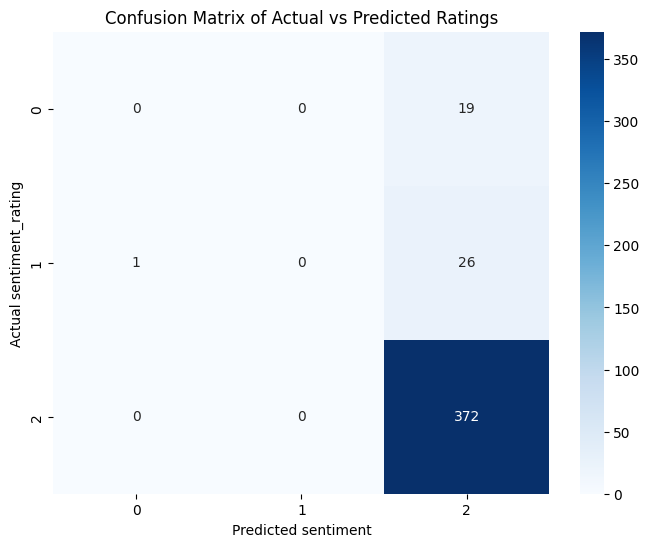

In [178]:
from sklearn.metrics import confusion_matrix


def map_rating_to_sentiment(rating):
    if rating <= 2:
        return 'negatif'
    elif rating <= 3:
        return 'neutre'
    else:
        return 'positif'

review_df['sentiment_rating'] = review_df['rating'].apply(map_rating_to_sentiment)

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(review_df['preprocessed_text2'], review_df['sentiment_rating'], test_size=0.3, random_state=123)

# Vectorisation TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Entraînement du modèle
model = RandomForestClassifier(random_state=123)
model.fit(X_train_tfidf, y_train)

# Prédiction et évaluation
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

# Supposons que y_test et y_pred contiennent vos vrais ratings et les ratings prédits
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualisation de la matrice de confusion
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted sentiment')
ax.set_ylabel('Actual sentiment_rating')
ax.set_title('Confusion Matrix of Actual vs Predicted Ratings')
plt.show()


              precision    recall  f1-score   support

     negatif       0.29      0.11      0.15        19
      neutre       0.20      0.04      0.06        27
     positif       0.90      0.98      0.94       372

    accuracy                           0.88       418
   macro avg       0.46      0.38      0.39       418
weighted avg       0.83      0.88      0.85       418



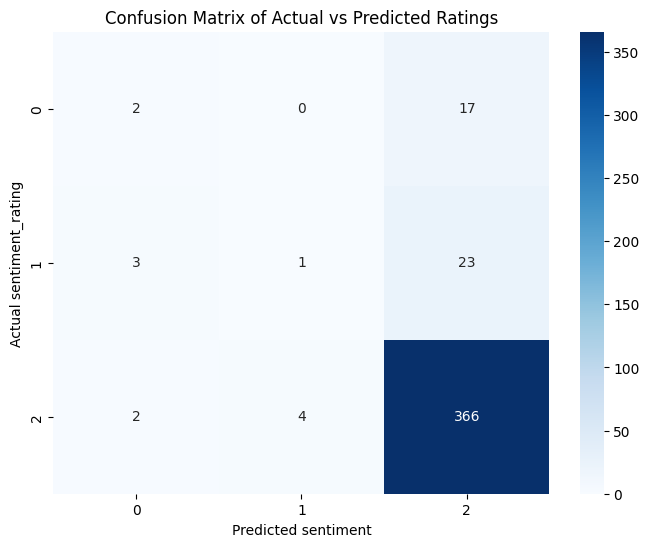

In [190]:
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# Paramètres à tester
param_grid = {
    'n_estimators': [10,50,100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

# Créer un modèle Random Forest
rf = RandomForestClassifier(random_state=123,class_weight='balanced_subsample')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# GridSearchCV pour trouver les meilleurs paramètres
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1_weighted')

grid_search.fit(X_train_tfidf, y_train)
best_rf = grid_search.best_estimator_

# Évaluation
y_pred = best_rf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

# Supposons que y_test et y_pred contiennent vos vrais ratings et les ratings prédits
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualisation de la matrice de confusion
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted sentiment')
ax.set_ylabel('Actual sentiment_rating')
ax.set_title('Confusion Matrix of Actual vs Predicted Ratings')
plt.show()


In [180]:
!pip install imbalanced-learn



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\sraps\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
108 fits failed out of a total of 162.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sraps\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sraps\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sraps\AppData\Local\Programs\Python\Python

              precision    recall  f1-score   support

     negatif       0.13      0.68      0.22        19
      neutre       0.28      0.19      0.22        27
     positif       0.96      0.77      0.85       372

    accuracy                           0.73       418
   macro avg       0.45      0.55      0.43       418
weighted avg       0.88      0.73      0.78       418



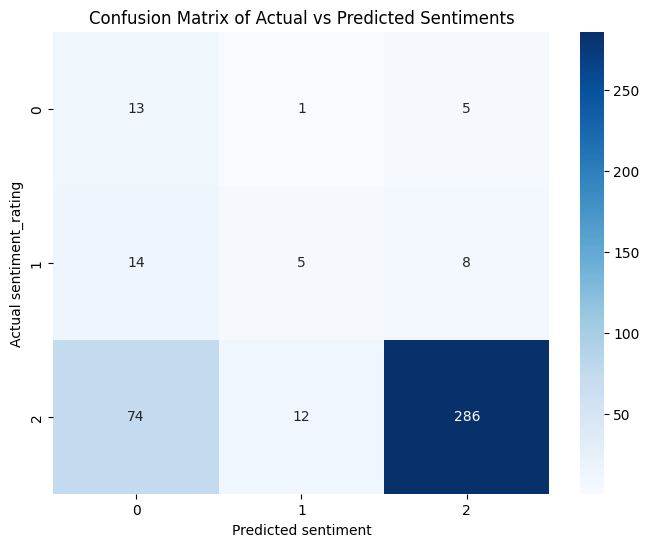

In [192]:
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

param_grid = {
    'n_estimators': [10, 50, 100],
    'base_estimator': [None, LogisticRegression(), SVC()],
    'sampling_strategy': ['auto', 0.5, 0.75],
    'replacement': [True, False]
}

# Easy Ensemble Classifier
easy_ensemble = EasyEnsembleClassifier(n_estimators=10, random_state=123)

# GridSearchCV
grid_search = GridSearchCV(easy_ensemble, param_grid, cv=3, n_jobs=-1, scoring='f1_weighted')
grid_search.fit(X_train_tfidf, y_train)
best_ensemble = grid_search.best_estimator_

# Prédiction et évaluation
y_pred = best_ensemble.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted sentiment')
ax.set_ylabel('Actual sentiment_rating')
ax.set_title('Confusion Matrix of Actual vs Predicted Sentiments')
plt.show()